# Fall 2020: DS-GA 1011 NLP with Representation Learning
## Lab 5: 02-Oct-2020, Friday
## Distributional word representations
In this lab, we want to explore creating vector representations of words (__distributed representations__) from co-occurence patterns in text.

Note that the term __embedding__, __word vector__, or __word embedding__ can also be used for distributed representations.

---
### Distributional matrices
Here's a basic recipe for building a word $\times$ word matrix:
    
0. Define a notion of co-occurrence context. This could be an entire document, a paragraph, a sentence, a clause, an NP — whatever domain seems likely to capture the associations you care about.
0. Scan through your corpus building a dictionary $d$ mapping word-pairs to counts. Every time a pair of words $w$ and $w'$ occurs in the same context (as you defined it in 1),  increment $d[(w, w')]$ by $1$.
0. Using the count dictionary $d$ that you collected in 2, establish your full vocabulary $V$, an ordered list of words types. For large collections of documents, $|V|$ will typically be huge. You will probably want to winnow the vocabulary at this point. You might do this by filtering to a specific subset, or just imposing a minimum count threshold. You might impose a minimum count threshold even if $|V|$ is small &mdash; for words with very low counts, you simply don't have enough evidence to say anything interesting.
0. Now build a matrix $M$ of dimension $|V| \times |V|$. Both the rows and the columns of $M$ represent words. Each cell $M[i, j]$ is filled with the count $d[(w_i, w_j)]$.

For different designs, the procedure differs slightly. For example, if you are building a word $\times$ document matrix, then the rows of $M$ represent words and the columns of $M$ represent documents. The scan in step 2 then just keeps track of (_word_, _document_) pairs &mdash; compiling the number of times that _word_ appears in _document_. Such matrices are often used in information retrieval, because the columns are multi-set representations of documents. They are much sparser than the the word $\times$ word matrices we will work with here. (In my experience, they yield lower-quality lexicons, but others have reported good results with them.)

Let's practice building a co-occurrence matrix. We'll use data from the [Stanford Sentiment Treebank](https://nlp.stanford.edu/sentiment/). Download the main zip and extract the file `datasetSentences.txt`.

We want to build a co-occurrence matrix where words are considered co-oocurring if they are adjacent in a sentence. Let's implement this function.

Some practical notes:
- for the project, it's okay to use outside libraries, but it's good practice to implement things from scratch
- try to stick to built-in Python data structures as much as possible, as using library data structures can add bloat and slow things down. Building the co-occurrence matrix should generally be pretty fast as it only requires one pass over the data, except instantiating the full matrix may be somewhat slow.

In [1]:
# Import required packages
import time
import numpy as np
from collections import defaultdict

cf.
> [`time`](https://docs.python.org/3/library/time.html) module provides various time-related functions. `time()` function returns the time in seconds since the 'epoch' (platform dependent start date) as a floating point number.

In [2]:
def load_sst(data_file):
    with open(data_file, 'r') as data_fh:
        data_fh.readline() # skip the header
        data = [r.split('\t')[1] for r in data_fh.readlines()]
    return data

In [3]:
def build_cooccurrence_matrix(data, max_vocab_size=20000):
    """ 
    args:
        - data: iterable where each item is a string sentence
        - max_vocab_size: maximum vocabulary size
        
    returns:
        - coocur_mat: co-occurrence matrix as a numpy array
    """
    
    def get_token_frequencies():
        tok2freq = defaultdict(int)
        coocur_counts = defaultdict(lambda: defaultdict(int))

        for datum in data:
            tokens = datum.strip().split() # we'll use whitespace to tokenize
            for i, tok in enumerate(tokens):
                tok2freq[tok] += 1
                coocur_counts[tok][tok] += 1
                if i < len(tokens) - 1:
                    coocur_counts[tok][tokens[i+1]] += 1
                    coocur_counts[tokens[i+1]][tok] += 1
        return tok2freq, coocur_counts
    
    def prune_vocabulary(tok2freq, max_vocab_size):
        """ Prune vocab by taking max_vocab_size most frequent words """
        tok_and_freqs = [(k, v) for k, v in tok2freq.items()]
        tok_and_freqs.sort(key = lambda x: x[1], reverse=True) # sorts in-place
        tok2idx = {tok: idx for idx, (tok, _) in enumerate(tok_and_freqs[:max_vocab_size])}
        idx2tok = {idx: tok for tok, idx in tok2idx.items()}
        return tok2idx, idx2tok
    
    def _build_coocurrence_mat(idx2tok, coocur_counts):
        #mat = [[coocur_counts[idx2tok[i]][idx2tok[j]] for j in range(len(idx2tok))] for i in range(len(idx2tok))]
        vocab_size = len(idx2tok)
        mat = [[0 for _ in range(vocab_size)] for _ in range(vocab_size)]
        for i in range(vocab_size - 1):
            for j in range(i+1, vocab_size):
                if coocur_counts[idx2tok[i]][idx2tok[j]]:
                    mat[i][j] = coocur_counts[idx2tok[i]][idx2tok[j]]
                    mat[j][i] = coocur_counts[idx2tok[i]][idx2tok[j]]
        return np.array(mat)
        
    print("Counting words...")
    start_time = time.time()
    tok2freq, coocur_counts = get_token_frequencies()
    print("\tFinished counting words in %.5f" % (time.time() - start_time))

    print("Pruning vocabulary...")
    tok2idx, idx2tok = prune_vocabulary(tok2freq, max_vocab_size)
    start_time = time.time()
    print("\tFinished pruning vocabulary in %.5f" % (time.time() - start_time))
    
    print("Building co-occurrence matrix...")
    start_time = time.time()
    coocur_mat = _build_coocurrence_mat(idx2tok, coocur_counts)
    print("\tFinished building co-occurrence matrix in %.5f" % (time.time() - start_time))
    return coocur_mat, tok2idx, idx2tok

In [4]:
data_file = 'stanfordSentimentTreebank/datasetSentences.txt'

data = load_sst(data_file)
mat, tok2idx, idx2tok = build_cooccurrence_matrix(data, max_vocab_size=10000)

Counting words...
	Finished counting words in 0.28962
Pruning vocabulary...
	Finished pruning vocabulary in 0.00000
Building co-occurrence matrix...
	Finished building co-occurrence matrix in 24.65094


We now have distributed, distributional word representations! Each row of this co-occurrence matrix can be seen as a word vector, nice!

---
### Vector comparison

A key operation on word vectors is being able to compare them. For the most part, we are interested in measuring the _distance_ between vectors. We surmise that semantically related words should be close together and semantically unrelated words should be far apart in the vector spaces we build.

#### Euclidean distance

The most basic and intuitive distance measure between vectors is __euclidean distance__. The euclidean distance between two vectors $u$ and $v$ of dimension $n$ is 

$$\sqrt{\sum_{i=1}^{n} |u_{i}-v_{i}|^2}$$ 

In two-dimensions, this corresponds to the length of the most direct line between the two points.

As part of the exercise, implement this without using any other packages (including the one shared for reference) beyond what has been imported already.

In [ ]:
def euclidean(u, v):    
    """Eculidean distance between 1d np.arrays `u` and `v`, which must 
    have the same dimensionality. Returns a float."""
    raise NotImplementedError

Here's a tiny vector space:

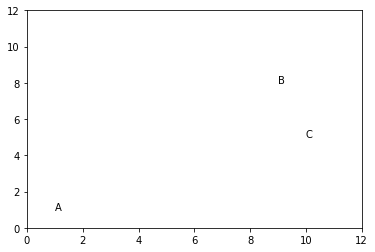

In [6]:
import matplotlib.pyplot as plt

ABC = np.array([
    [ 1.0,  1.0],  # A
    [9.0, 8.0],  # B
    [10.0, 5.0]]) # C

def plot_ABC(m):
    plt.plot(m[:,0], m[:,1], marker='', linestyle='')
    plt.xlim([0,np.max(m)*1.2])
    plt.ylim([0,np.max(m)*1.2])
    for i, x in enumerate(['A','B','C']):
        plt.annotate(x, m[i,:])

plot_ABC(ABC)

The euclidean distances align well with the raw visual distance in the plot:

In [7]:
euclidean(ABC[0], ABC[1])

10.63014581273465

In [8]:
euclidean(ABC[1], ABC[2])

3.1622776601683795

#### Length normalization

Suppose we believed that vector B should be closer to vector A than to vector C. The Euclidean distances do not reflect that relationship.

One strategy to impose this relationship is to normalize the vectors. We might normalize each vector by its __length__, which is defined for a vector $u$ of dimension $n$ as 

$$\|u\| = \sqrt{\sum_{i=1}^{n} u_{i}^{2}}$$ 

Please fill in `vector_length` below without using any new modules:

In [ ]:
def vector_length(u):
    """Length (L2) of the 1d np.array `u`. Returns a new np.array with the 
    same dimensions as `u`."""
    raise NotImplementedError

Let's use our function to write a length-normalizing function.

In [10]:
def length_norm(u):
    """L2 norm of the 1d np.array `u`. Returns a float."""
    return u / vector_length(u)

Normalization changes the affinity or distance between points A, B, and C dramatically. Is normalization the right thing to do?

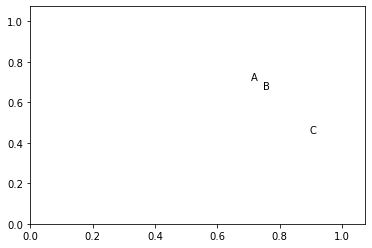

In [11]:
plot_ABC(np.array([length_norm(row) for row in ABC]))

Here, the connection between A and B is more apparent, as is the opposition between B and C.

#### Cosine distance

Implicitly, we have replaced Euclidean distance as our distance metric with cosine distance. __Cosine distance__ takes overall length into account. The cosine distance between two vectors $u$ and $v$ of dimension $n$ is 

$$1 - \left(\frac{\sum_{i=1}^{n} u_{i} \cdot v_{i}}{\|u\|\cdot \|v\|}\right)$$

The similarity part of this (the righthand term of the subtraction) is actually measuring the _angles_ between the two vectors. The result is the same (in terms of rank order) as one gets from first normalizing both vectors using `vector_length` and then calculating their Euclidean distance.

Implement this below:

In [ ]:
def cosine(u, v):        
    """Cosine distance between 1d np.arrays `u` and `v`, which must have 
    the same dimensionality. Returns a float."""
    raise NotImplementedError

#### Other distance measures

It is very common to use Euclidean and cosine distance, but there are other distance measures one might consider using. For example, the particular definition of length we used is the L2-norm (because of the $^2$ exponent); we might consider using a different exponent such as $^1$, yielding the L1-norm.

As practice, let's consider the Jaccard distance, which is defined as 

$$ J(u, v) = 1 - \left( \frac{\sum_{i} min(u_i, v_i)}{\sum_{i} max(u_i, v_i) } \right) $$

Jaccard distance measures how dissimilar two vectors are by comparing their "intersection" and "union" (it's usually defined in context of sets). Let's implement this:

In [ ]:
def jaccard(u, v):
    """Jaccard similarity between two real-valued vectors"""
    raise NotImplementedError

A recent line of work is in learning _hyperbolic_ word embeddings, where the embeddings live in a non-Euclidean, hyperbolic space. The appeal of this approach is that the learned embeddings can respect the hierarchical relationship that some words have with each other.

For more information, see [Nickel and Kiela (2017)](https://arxiv.org/abs/1705.08039) or [Chamberlain et al. (2017)](https://arxiv.org/abs/1705.10359).

#### Summary

Suppose we set for ourselves the goal of associating A with B and disassociating B from C, in keeping with the semantic intuition expressed above. Then we can assess distance measures by whether they achieve this goal:

In [14]:
for m in (euclidean, cosine, jaccard):
    fmt = {'n': m.__name__,  
           'AB': m(ABC[0], ABC[1]), 
           'BC': m(ABC[1], ABC[2])}
    print('%(n)15s(A, B) = %(AB)5.3f %(n)15s(B, C) = %(BC)5.3f' % fmt)

      euclidean(A, B) = 10.630       euclidean(B, C) = 3.162
         cosine(A, B) = 0.002          cosine(B, C) = 0.034
        jaccard(A, B) = 0.882         jaccard(B, C) = 0.222


cf.
>[`numpy.linalg.norm`](https://numpy.org/doc/stable/reference/generated/numpy.linalg.norm.html) or [`scipy.linalg.norm`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.linalg.norm.html#scipy.linalg.norm) returns vector or matrix norm

>[`scipy.spatial.distance.cdist`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.cdist.html) computes distance between each pair of the two collections of inputs

---
### Distributional neighbors

The `neighbors` function is an investigative aide. For a given `word`, it ranks all the words in the vocabulary `rownames` according to their distance from `word`, as measured by `distfunc` in matrix `mat`:

In [15]:
def neighbors(tok, mat, tok2idx, idx2tok, distfunc=cosine):    
    """Tool for finding the nearest neighbors of `word` in `mat` according 
    to `distfunc`. The comparisons are between row vectors.
    
    Parameters
    ----------
    tok : str
        The anchor word. Assumed to be in `tok2idx`.
        
    mat : np.array
        The vector-space model.
        
    tok2idx : list of str
        The rownames of mat.
            
    distfunc : function mapping vector pairs to floats (default: `cosine`)
        The measure of distance between vectors. Can also be `euclidean`, 
        `matching`, `jaccard`, as well as any other distance measure  
        between 1d vectors.
    
    Returns
    -------    
    list of tuples
        The list is ordered by closeness to `word`. Each member is a pair 
        (word, distance) where word is a str and distance is a float.
    
    """
    if tok not in tok2idx:
        raise ValueError('%s is not in this VSM' % tok)
    w = mat[tok2idx[tok]]
    dists = [(idx2tok[i], distfunc(w, mat[i])) for i in range(len(mat))]
    return sorted(dists, key=lambda x: x[1], reverse=False)

By playing around with this function, you can start to get a sense for how the distance functions differ. Here are some example calls; you might try some new words to get a feel for what these matrices are like and how different words look.

In [16]:
neighbors(tok='superb', mat=mat, tok2idx=tok2idx, idx2tok=idx2tok, distfunc=euclidean)[:10]

[('superb', 0.0),
 ('cipher', 4.69041575982343),
 ('illuminated', 4.69041575982343),
 ('Using', 4.795831523312719),
 ('spine', 4.795831523312719),
 ('legend', 4.898979485566356),
 ('shining', 4.898979485566356),
 ('lick', 4.898979485566356),
 ('bravura', 4.898979485566356),
 ('stellar', 4.898979485566356)]

In [17]:
neighbors(tok='superb', mat=mat, tok2idx=tok2idx, idx2tok=idx2tok, distfunc=cosine)[:10]

<ipython-input-12-f8317b7dac6a>:4: RuntimeWarning: invalid value encountered in true_divide
  return 1.0 - (np.dot(u, v) / (vector_length(u) * vector_length(v)))


[('superb', 1.1102230246251565e-16),
 ('cipher', 0.5219085562662426),
 ('fellow', 0.5271337562565397),
 ('illuminated', 0.527544408738466),
 ('terrific', 0.5281792278953805),
 ('solid', 0.538018447402505),
 ('wonderful', 0.5496408554571595),
 ('fault', 0.5552504100033393),
 ('good', 0.560877926872458),
 ('Using', 0.5635642195280153)]

These rankings are okay, with `cosine` less likely to associate words that happen to have similar frequency, but somewhat noisy. 

---
### Matrix reweighting

*Reweighting* aims to amplify the important, trustworthy, and unusual, while deemphasizing the mundane and the quirky. The intuition behind moving away from raw counts is that just using frequency is too fuzzy a concept for our goal of encoding semantics.

*Normalization* (row-wise or column-wise) is perhaps the simplest form of reweighting. With [length_norm](#Length-normalization), we normalize using `vector_length`. We can also normalize each row by the sum of its values, which turns each row into a probability distribution over the columns:

In [18]:
def prob_norm(u):
    """Normalize 1d np.array `u` into a probability distribution. Assumes 
    that all the members of `u` are positive. Returns a 1d np.array of 
    the same dimensionality as `u`."""
    return u / np.sum(u)

def rowwise_norm_mat(mat):
    return np.array([prob_norm(u) for u in mat])

In [19]:
norm_mat = rowwise_norm_mat(mat)

<ipython-input-18-c7b72c0a97d4>:5: RuntimeWarning: invalid value encountered in true_divide
  return u / np.sum(u)


Key point: These normalization measures are insensitive to the _magnitude_ of the underlying counts. 

This is often a mistake in the messy world of large data sets; $[1,10]$ and $[1000,10000]$ are very different in ways that will be partly or totally obscured by normalization.

How do we solve this? Pointwise mutual information!

---
### Dimensionality reduction
The above methods deliver solid results. However, they are not capable of capturing higher-order associations in the data. For example, both _gnarly_ and _wicked_ are used as slangily positive adjectives. We thus expect them to have many of the same neighbors. However, at least stereotypically, _gnarly_ is Californian and _wicked_ is Bostonian. Thus, they are unlikely 
to occur often in the same texts. Dimensionality reduction techniques are often capable of capturing their semantic similarity (and have the added advantage of shrinking the size of our data structures).

The general goal of dimensionality reduction is to eliminate rows/columns that are highly correlated while bringing similar things together and pushing dissimilar things apart. __Latent Semantic Analysis__ (LSA) is a prominent method. It is an application of truncated __singular value decomposition__ (SVD). SVD is a central matrix operation; 'truncation' here means looking only at submatrices of the full decomposition. LSA seeks not only to find a reduced-sized matrix but also to capture similarities that come not just from direct co-occurrence, but also from second-order co-occurrence.

Dimensionality reduction is also particularly helpful in our case because our vectors are very sparse. Intuitively, many words don't often appear right next to each other, so many entries in the word vectors are zero. By reducing our word vectors, we won't need to pass around very large vectors and remove some of the sparsity.

In [20]:
from numpy.linalg import svd

cf.
>[`numpy.linalg.svd`](https://numpy.org/doc/stable/reference/generated/numpy.linalg.svd.html) performs Singular Value Decomposition. Also, [`scipy.linalg.svd`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.linalg.svd.html#scipy.linalg.svd) 

In [21]:
def lsa(mat=None, k=100):
    """Latent Semantic Analysis using pure scipy.
    
    Parameters
    ----------
    mat : 2d np.array
       The matrix to operate on.
        
    k : int (default: 100)
        Number of dimensions to truncate to.
        
    Returns
    -------    
    (np.array, list of str)
        The first member is the SVD-reduced version of `mat` with 
        dimension (m x k), where m is the rowcount of mat and `k` is 
        either the user-supplied k or the column count of `mat`, whichever 
        is smaller. The second member is `rownames` (unchanged).

    """    
    rowmat, singvals, colmat = svd(mat, full_matrices=False)
    singvals = np.diag(singvals)
    trunc = np.dot(rowmat[:, 0:k], singvals[0:k, 0:k])
    return trunc

Here's a look at the following example:

In [22]:
gnmat = np.array([
    [1,0,1,0,0,0],
    [0,1,0,1,0,0],
    [1,1,1,1,0,0],
    [0,0,0,0,1,1],
    [0,0,0,0,0,1]], dtype='float64')
gn_idx2tok = {0:'gnarly', 1:'wicked', 2:'awesome', 3:'lame', 4:'terrible'}
gn_tok2idx = {v: k for k, v in gn_idx2tok.items()}

In [23]:
neighbors(tok='gnarly', mat=gnmat, tok2idx=gn_tok2idx, idx2tok=gn_idx2tok, distfunc=cosine)

[('gnarly', 2.220446049250313e-16),
 ('awesome', 0.29289321881345254),
 ('wicked', 1.0),
 ('lame', 1.0),
 ('terrible', 1.0)]

We see that _gnarly_ and _wicked_ are not close to each other. (Well, it's a small space, but they are as close as _gnarly_ and _lame_.) Reweighting by PMI, PPMI, or TF-IDF is no help. LSA to the rescue:

In [24]:
gnmat_lsa = lsa(mat=gnmat, k=2)

In [25]:
neighbors(tok='gnarly', mat=gnmat_lsa, tok2idx=gn_tok2idx, idx2tok=gn_idx2tok, distfunc=cosine)

[('gnarly', 0.0),
 ('wicked', 0.0),
 ('awesome', 0.0),
 ('lame', 1.0),
 ('terrible', 1.0)]

---
### Evaluation: Word Similarity

We've done a good deal of work creating these word vectors, but how do we know how good they are? Inspecting the neighbors of words according to their vectors and making sure they match our intuition is a good hueristic.

Expanding on this idea, we can evaluate the quality of word vectors by using them to compute similarities of pairs of words and then comparing those similarities to human judgments. Let's use this strategy to evaluate the word vectors we just learned. We'll use the [MTurk-771](http://www2.mta.ac.il/~gideon/mturk771.html) word similarity dataset.

In [26]:
def load_word_similarity_dataset(data_file):
    with open(data_file, 'r') as data_fh:
        raw_data = data_fh.readlines()
    data = []
    trgs = []
    for datum in raw_data:
        datum = datum.strip().split(',')
        data.append((datum[0], datum[1]))
        trgs.append(float(datum[2]))
    return data, trgs

In [27]:
from scipy.stats import spearmanr

cf.
>[`scipy.stats.spearmanr`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.spearmanr.html) calculates Spearman correlation coefficient

In [28]:
def evaluate_word_similarity(word_pairs, targets, mat, tok2idx):
    """ """
    preds = []
    trgs = []
    n_exs = 0
    for (word1, word2), trg in zip(word_pairs, targets):
        if word1 in tok2idx and word2 in tok2idx:
            pred_sim = 1 - cosine(mat[tok2idx[word1]], mat[tok2idx[word2]])
            preds.append(pred_sim)
            trgs.append(trg)
            n_exs += 1
    
    rho, pvalue = spearmanr(trgs, preds)
    print("Evaluated on %d of %d examples" % (n_exs, len(word_pairs)))
    return rho

In [29]:
test_file = 'MTURK-771.csv'
test_data, test_trgs = load_word_similarity_dataset(test_file)

In [30]:
evaluate_word_similarity(test_data, test_trgs, norm_mat, tok2idx)

Evaluated on 248 of 771 examples


0.024826560560269804

---
### Pre-trained Word Embeddings/Models
Our word vectors aren't very good (NLP isn't that easy...). There are some great pre-computed matrices available online too. These aren't matrices of counts, but rather more abstract values computed using methods like those under discussion here. [GloVe](https://nlp.stanford.edu/projects/glove/) is a unsupervised learning algorithm that learns vector representations of words using word-to-word cooccurence matrices from a corpus. 

Code below loads the GloVe vectors (you don't necessarily need to load *all* of them) and evaluates them on MTurk-771.

In [31]:
def load_glove(glove_file, n_vecs=20000):
    """ """
    tok2vec = {}
    with open(glove_file, 'r') as glove_fh:
        for i, row in enumerate(glove_fh):
            word, vec = row.split(' ', 1)
            tok2vec[word] = np.array([float(n) for n in vec.split(' ')])
            if i >= n_vecs:
                break
    return tok2vec

def glove_evaluate_word_similarity(word_pairs, targets, glove_vecs):
    """ """
    preds = []
    trgs = []
    n_exs = 0
    for (word1, word2), trg in zip(word_pairs, targets):
        if word1 in glove_vecs and word2 in glove_vecs:
            pred_sim = 1 - cosine(glove_vecs[word1], glove_vecs[word2])
            preds.append(pred_sim)
            trgs.append(trg)
            n_exs += 1
    
    rho, pvalue = spearmanr(trgs, preds)
    print("Evaluated on %d of %d examples" % (n_exs, len(word_pairs)))
    return rho

In [32]:
# glove_file = "glove.840B.300d.txt"
glove_file = "glove/glove.6B.300d.txt"

glove_vecs = load_glove(glove_file, n_vecs=50000)

In [33]:
glove_evaluate_word_similarity(test_data, test_trgs, glove_vecs)

Evaluated on 771 of 771 examples


0.6500829276838272

Other popular open-source models/libraries:
- [word2vec](https://code.google.com/archive/p/word2vec/) (Google): This tool provides an efficient implementation of the continuous bag-of-words and skip-gram architectures for computing vector representations of words.
- [fastText](https://fasttext.cc) (Facebook): FastText is an open-source, free, lightweight library that allows users to learn text representations and text classifiers. It works on standard, generic hardware. Models can later be reduced in size to even fit on mobile devices.

---
## References
- CS224U Natural Language Understanding Spring 2016
- DS-GA 1012 Natural Language Understanding Spring 2019